<a href="https://colab.research.google.com/github/blakelobato/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/213A_Ridge_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html). Use the scaler's `fit_transform` method with the train set. Use the scaler's `transform` method with the test set.
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [0]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [0]:
df.BUILDING_CLASS_CATEGORY.value_counts

<bound method IndexOpsMixin.value_counts of 0          13 CONDOS - ELEVATOR APARTMENTS
1                      21 OFFICE BUILDINGS
2                      21 OFFICE BUILDINGS
3          13 CONDOS - ELEVATOR APARTMENTS
4        15 CONDOS - 2-10 UNIT RESIDENTIAL
                       ...                
23035              01 ONE FAMILY DWELLINGS
23036         09 COOPS - WALKUP APARTMENTS
23037       10 COOPS - ELEVATOR APARTMENTS
23038              02 TWO FAMILY DWELLINGS
23039        12 CONDOS - WALKUP APARTMENTS
Name: BUILDING_CLASS_CATEGORY, Length: 23040, dtype: object>

In [0]:
top10

Index(['FLUSHING-NORTH', 'UPPER EAST SIDE (59-79)', 'UPPER EAST SIDE (79-96)',
       'BEDFORD STUYVESANT', 'BOROUGH PARK', 'UPPER WEST SIDE (59-79)',
       'GRAMERCY', 'ASTORIA', 'FOREST HILLS', 'EAST NEW YORK'],
      dtype='object')

Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.

In [0]:
df['BUILDING_CLASS_CATEGORY'] = df['BUILDING_CLASS_CATEGORY'].str[3:]

In [0]:
df = df[(df.SALE_PRICE > 10000) & (df.SALE_PRICE < 2000000 )]

In [0]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
66,1,OTHER,COOPS - ELEVATOR APARTMENTS,2,1347,18,NaN,D4,"345 EAST 54TH ST, 3B",NaN,10022.0,0.0,0.0,0.0,0,0.0,1960.0,2,D4,330000,01/02/2019
67,1,UPPER EAST SIDE (79-96),COOPS - ELEVATOR APARTMENTS,2,1491,62,NaN,D4,"16 EAST 80TH STREET, 2A",NaN,10075.0,0.0,0.0,0.0,0,0.0,1925.0,2,D4,600000,01/02/2019
71,1,UPPER WEST SIDE (59-79),CONDOS - ELEVATOR APARTMENTS,2,1171,2200,NaN,R4,"240 RIVERSIDE BOULEVARD, 4 F",4 F,10069.0,1.0,0.0,1.0,0,827.0,2004.0,2,R4,1250000,01/02/2019


In [0]:
df = df.drop(columns=['EASE-MENT'])

In [0]:
df.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [0]:
df.BUILDING_CLASS_CATEGORY.value_counts

<bound method IndexOpsMixin.value_counts of 44               ONE FAMILY DWELLINGS
61               ONE FAMILY DWELLINGS
66        COOPS - ELEVATOR APARTMENTS
67        COOPS - ELEVATOR APARTMENTS
71       CONDOS - ELEVATOR APARTMENTS
                     ...             
23035            ONE FAMILY DWELLINGS
23036       COOPS - WALKUP APARTMENTS
23037     COOPS - ELEVATOR APARTMENTS
23038            TWO FAMILY DWELLINGS
23039      CONDOS - WALKUP APARTMENTS
Name: BUILDING_CLASS_CATEGORY, Length: 13709, dtype: object>

In [0]:
mask = (df['BUILDING_CLASS_CATEGORY'] == 'ONE FAMILY DWELLINGS')
df = df[mask]

In [0]:
df.head()
#now we have over 10000 or less than 2000000 for the prices and only one family dwelling

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [0]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])
df['MONTH_CREATED'] = df['SALE_DATE'].dt.month
df.MONTH_CREATED.describe()
#creates a new feature of months

count    3193.000000
mean        2.358284
std         1.114403
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: MONTH_CREATED, dtype: float64

In [0]:
#creates our new train and test data
train = df.query('MONTH_CREATED < 4')
#train data now before april
test = df.query('MONTH_CREATED  > =4')
#test data after april

In [0]:
print(train.shape)
train.head()

(2543, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,MONTH_CREATED
44,3,OTHER,ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01,1
61,4,OTHER,ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01,1
78,2,OTHER,ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02,1
108,3,OTHER,ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02,1
111,3,OTHER,ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02,1


In [0]:
print(test.shape)
test.head()

(650, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,MONTH_CREATED
18235,2,OTHER,ONE FAMILY DWELLINGS,1,5913,878,A1,4616 INDEPENDENCE AVENUE,NaN,10471.0,1.0,0.0,1.0,"5,000",2272.0,1930.0,1,A1,895000,2019-04-01,4
18239,2,OTHER,ONE FAMILY DWELLINGS,1,5488,48,A2,558 ELLSWORTH AVENUE,NaN,10465.0,1.0,0.0,1.0,"2,500",720.0,1935.0,1,A2,253500,2019-04-01,4
18244,3,OTHER,ONE FAMILY DWELLINGS,1,5936,31,A1,16 BAY RIDGE PARKWAY,NaN,11209.0,1.0,0.0,1.0,"2,880",2210.0,1925.0,1,A1,1300000,2019-04-01,4
18280,3,OTHER,ONE FAMILY DWELLINGS,1,7813,24,A5,1247 EAST 40TH STREET,NaN,11210.0,1.0,0.0,1.0,"1,305",1520.0,1915.0,1,A5,789000,2019-04-01,4
18285,3,OTHER,ONE FAMILY DWELLINGS,1,8831,160,A9,2314 PLUMB 2ND STREET,NaN,11229.0,1.0,0.0,1.0,"1,800",840.0,1925.0,1,A9,525000,2019-04-01,4


 Do one-hot encoding of categorical features.

In [0]:
df.BUILDING_CLASS_AT_PRESENT.value_counts

<bound method IndexOpsMixin.value_counts of 44       A9
61       A1
78       A1
108      A1
111      A5
         ..
23029    A2
23031    A1
23032    A0
23033    A1
23035    A5
Name: BUILDING_CLASS_AT_PRESENT, Length: 3193, dtype: object>

In [0]:
train.select_dtypes(exclude='number').describe().T

,count,unique,top,freq,first,last
BOROUGH,2543,5,4,1221,NaT,NaT
NEIGHBORHOOD,2543,7,OTHER,2393,NaT,NaT
BUILDING_CLASS_CATEGORY,2543,1,ONE FAMILY DWELLINGS,2543,NaT,NaT
TAX_CLASS_AT_PRESENT,2543,2,1,2512,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2543,13,A1,928,NaT,NaT
ADDRESS,2543,2531,294 FREEBORN STREET,2,NaT,NaT
APARTMENT_NUMBER,1,1,RP.,1,NaT,NaT
LAND_SQUARE_FEET,2543,893,"4,000",236,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2543,11,A1,928,NaT,NaT
SALE_DATE,2543,69,2019-01-31 00:00:00,78,2019-01-01,2019-03-30


In [0]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'NEIGHBORHOOD', 'APARTMENT_NUMBER', 'LAND_SQUARE_FEET', 'SALE_DATE']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [0]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [0]:
X_test.columns

Index(['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_5', 'BOROUGH_1',
       'BUILDING_CLASS_CATEGORY_ONE FAMILY DWELLINGS',
       'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D', 'BLOCK', 'LOT',
       'BUILDING_CLASS_AT_PRESENT_A9', 'BUILDING_CLASS_AT_PRESENT_A1',
       'BUILDING_CLASS_AT_PRESENT_A5', 'BUILDING_CLASS_AT_PRESENT_A0',
       'BUILDING_CLASS_AT_PRESENT_A2', 'BUILDING_CLASS_AT_PRESENT_A3',
       'BUILDING_CLASS_AT_PRESENT_S1', 'BUILDING_CLASS_AT_PRESENT_A4',
       'BUILDING_CLASS_AT_PRESENT_A6', 'BUILDING_CLASS_AT_PRESENT_A8',
       'BUILDING_CLASS_AT_PRESENT_B2', 'BUILDING_CLASS_AT_PRESENT_S0',
       'BUILDING_CLASS_AT_PRESENT_B3', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE_A9',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A1',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A5',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A0',
       'BUILDING_

In [0]:
print(X_train.shape)
X_train.head()


(2543, 42)


,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,BUILDING_CLASS_CATEGORY_ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0,MONTH_CREATED
44,1,0,0,0,0,1,1,0,5495,801,1,0,0,0,0,0,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,1,0,0,0,0,0,0,0,0,0,0,1
61,0,1,0,0,0,1,1,0,7918,72,0,1,0,0,0,0,0,0,0,0,0,0,0,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,0,1,0,0,0,0,0,0,0,0,0,1
78,0,0,1,0,0,1,1,0,4210,19,0,1,0,0,0,0,0,0,0,0,0,0,0,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0,1
108,1,0,0,0,0,1,1,0,5212,69,0,1,0,0,0,0,0,0,0,0,0,0,0,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,0,1,0,0,0,0,0,0,0,0,0,1
111,1,0,0,0,0,1,1,0,7930,121,0,0,1,0,0,0,0,0,0,0,0,0,0,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,0,0,1,0,0,0,0,0,0,0,0,1


In [0]:
print(X_test.shape)
X_test.head()

(650, 42)


,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,BUILDING_CLASS_CATEGORY_ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0,MONTH_CREATED
18235,0,0,1,0,0,1,1,0,5913,878,0,1,0,0,0,0,0,0,0,0,0,0,0,10471.0,1.0,0.0,1.0,2272.0,1930.0,1,0,1,0,0,0,0,0,0,0,0,0,4
18239,0,0,1,0,0,1,1,0,5488,48,0,0,0,0,1,0,0,0,0,0,0,0,0,10465.0,1.0,0.0,1.0,720.0,1935.0,1,0,0,0,0,1,0,0,0,0,0,0,4
18244,1,0,0,0,0,1,1,0,5936,31,0,1,0,0,0,0,0,0,0,0,0,0,0,11209.0,1.0,0.0,1.0,2210.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0,4
18280,1,0,0,0,0,1,1,0,7813,24,0,0,1,0,0,0,0,0,0,0,0,0,0,11210.0,1.0,0.0,1.0,1520.0,1915.0,1,0,0,1,0,0,0,0,0,0,0,0,4
18285,1,0,0,0,0,1,1,0,8831,160,1,0,0,0,0,0,0,0,0,0,0,0,0,11229.0,1.0,0.0,1.0,840.0,1925.0,1,1,0,0,0,0,0,0,0,0,0,0,4


In [0]:
X_test.isna().sum()

BOROUGH_3                                       0
BOROUGH_4                                       0
BOROUGH_2                                       0
BOROUGH_5                                       0
BOROUGH_1                                       0
BUILDING_CLASS_CATEGORY_ONE FAMILY DWELLINGS    0
TAX_CLASS_AT_PRESENT_1                          0
TAX_CLASS_AT_PRESENT_1D                         0
BLOCK                                           0
LOT                                             0
BUILDING_CLASS_AT_PRESENT_A9                    0
BUILDING_CLASS_AT_PRESENT_A1                    0
BUILDING_CLASS_AT_PRESENT_A5                    0
BUILDING_CLASS_AT_PRESENT_A0                    0
BUILDING_CLASS_AT_PRESENT_A2                    0
BUILDING_CLASS_AT_PRESENT_A3                    0
BUILDING_CLASS_AT_PRESENT_S1                    0
BUILDING_CLASS_AT_PRESENT_A4                    0
BUILDING_CLASS_AT_PRESENT_A6                    0
BUILDING_CLASS_AT_PRESENT_A8                    0


Do feature selection with `SelectKBest`.

In [0]:
# TODO: Select the 25 features that best correlate with the target this is about half the amount
# (25 is an arbitrary starting point here)
from sklearn.feature_selection import f_regression, SelectKBest

# SelectKBest has a similar API to what we've seen before.
# IMPORTANT!
# .fit_transform on the train set
# .transform on test set
selector = SelectKBest(score_func=f_regression, k=25)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


(2543, 25)

In [0]:
# TODO: Which features were selected?
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features Selected:')
for name in selected_names:
  print(name)

print('')
print('Features Not Selected:')
for name in unselected_names:
  print(name)

Features Selected:
BOROUGH_3
BOROUGH_4
BOROUGH_2
BOROUGH_5
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
BLOCK
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A3
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_S0
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A3
BUILDING_CLASS_AT_TIME_OF_SALE_S1
BUILDING_CLASS_AT_TIME_OF_SALE_A4
BUILDING_CLASS_AT_TIME_OF_SALE_A6
BUILDING_CLASS_AT_TIME_OF_SALE_A8
BUILDING_CLASS_AT_TIME_OF_SALE_S0

Features Not Selected:
BOROUGH_1
BUILDING_CLASS_CATEGORY_ONE FAMILY DWELLINGS
LOT
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_B2
BUILDING_CLASS_AT_PRESENT_B3
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE
BUILDING_CLASS_AT_TIME_OF_SALE_A9
BUILDING_CLASS_AT_TIME_OF_SALE_A1
BUILDING_CL

In [0]:
# TODO: How many features should be selected?

# You can try a range of values for k,
# then choose the model with the best score.
# If multiple models "tie" for the best score,
# choose the simplest model.
# You decide what counts as a tie!
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns) + 1):
  print(f'{k} features:')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)

  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test MAE: ${mae:,.0f} \n')

  #32 features is best

1 features:
Test MAE: $185,715 

2 features:
Test MAE: $184,761 

3 features:
Test MAE: $184,761 

4 features:
Test MAE: $185,516 

5 features:
Test MAE: $183,398 

6 features:
Test MAE: $183,753 

7 features:
Test MAE: $177,246 

8 features:
Test MAE: $167,331 

9 features:
Test MAE: $167,125 

10 features:
Test MAE: $168,882 

11 features:
Test MAE: $168,296 

12 features:
Test MAE: $168,300 

13 features:
Test MAE: $168,040 

14 features:
Test MAE: $168,040 

15 features:
Test MAE: $167,942 

16 features:
Test MAE: $167,942 

17 features:
Test MAE: $168,012 

18 features:
Test MAE: $168,012 

19 features:
Test MAE: $168,012 

20 features:
Test MAE: $167,578 

21 features:
Test MAE: $167,480 

22 features:


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test MAE: $167,436 

23 features:
Test MAE: $167,562 

24 features:
Test MAE: $167,519 

25 features:
Test MAE: $167,429 

26 features:
Test MAE: $167,429 

27 features:
Test MAE: $166,954 

28 features:
Test MAE: $166,933 

29 features:
Test MAE: $166,904 

30 features:
Test MAE: $166,448 

31 features:
Test MAE: $166,448 

32 features:
Test MAE: $165,398 

33 features:
Test MAE: $165,437 

34 features:
Test MAE: $166,444 

35 features:


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test MAE: $166,469 

36 features:
Test MAE: $166,827 

37 features:
Test MAE: $166,827 

38 features:
Test MAE: $166,737 

39 features:
Test MAE: $166,702 

40 features:
Test MAE: $166,698 

41 features:
Test MAE: $166,698 

42 features:
Test MAE: $166,698 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

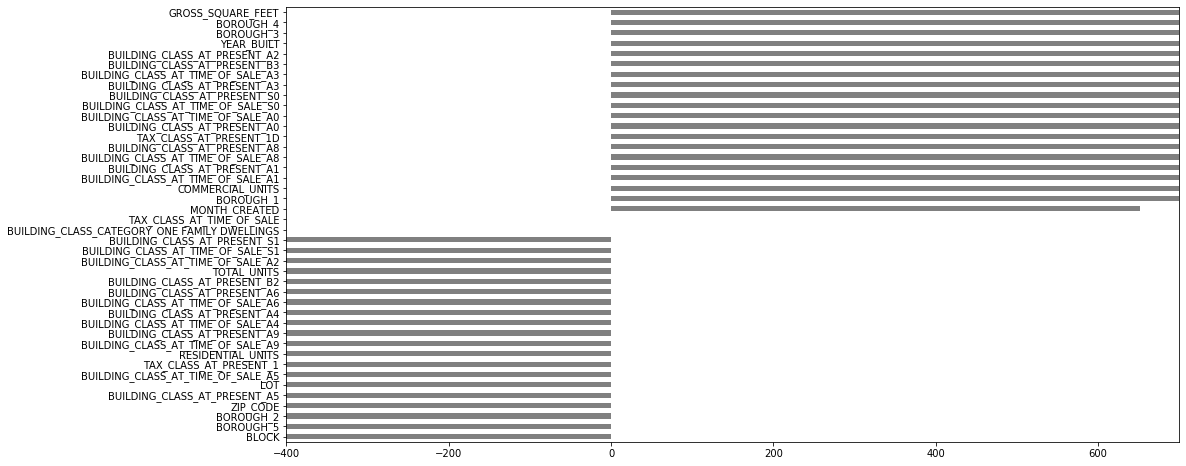

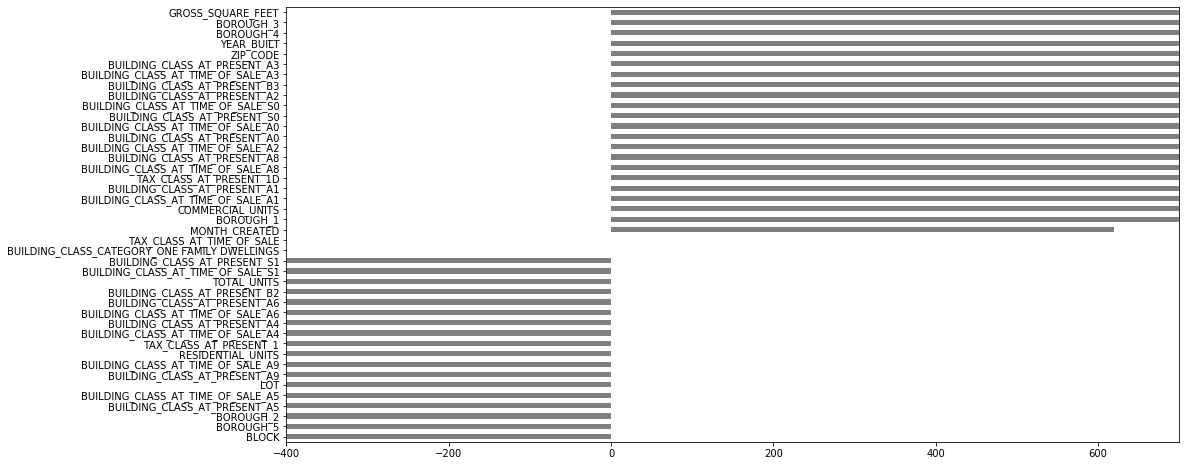

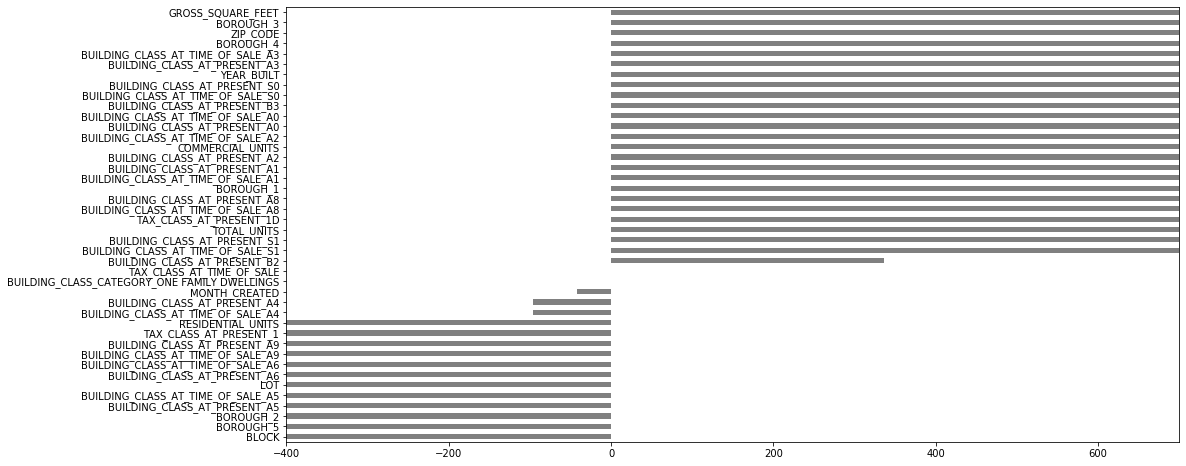

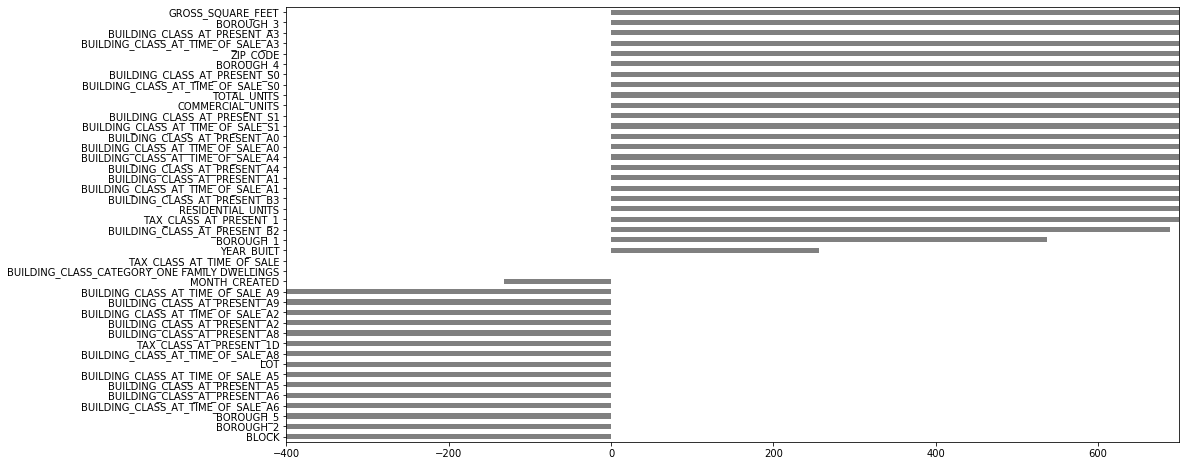

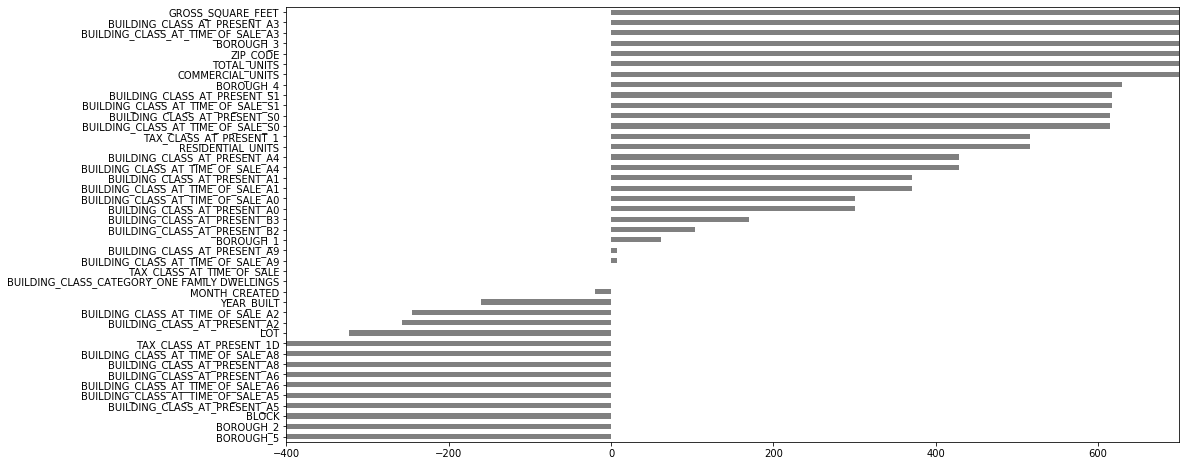

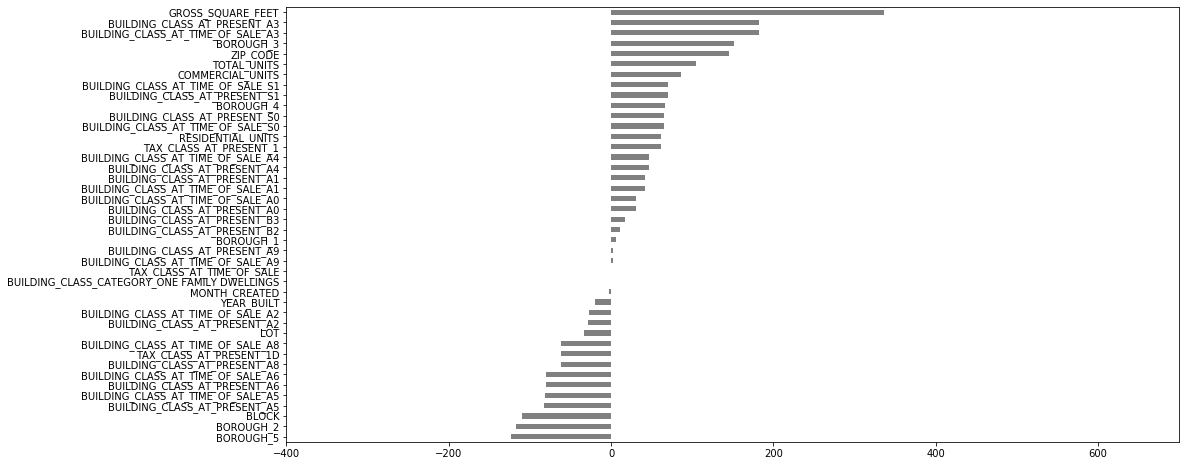

In [0]:
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


# Try a range of alpha parameters for Ridge Regression.

# The scikit-learn docs explain, 
# alpha : Regularization strength; must be a positive float. Regularization 
# improves the conditioning of the problem and reduces the variance of the 
# estimates. Larger values specify stronger regularization.
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

for alpha in [10**1, 10**2, 10**3, 10**4, 10**5, 10**6]:
    
    # Scale data before doing Ridge Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-400,700)
    plt.show()